In [54]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import cast_feature_dtypes, pull_data, pull_projections
from modeling import split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import AGG_YEARS, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

In [2]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Casting feature dtypes for batting & pitching dataframes
batting_df = cast_feature_dtypes(batting_df)
pitching_df = cast_feature_dtypes(pitching_df)

# Filtering pitchers from batting_df, they should not be included in the batter model
batting_df = batting_df[batting_df["pos_type"] != "Pitcher"].copy()
# Dropping pos_type and primary_pos from pitching_df as they are redundant (every player is a pitcher)
pitching_df = pitching_df.drop(columns=["pos_type", "primary_pos"]).copy()

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with 0 future fantasy points (would not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

Pulling data for year: 2005
Pulling data for year: 2006
Pulling data for year: 2007
Pulling data for year: 2008
Pulling data for year: 2009
Pulling data for year: 2010
Pulling data for year: 2011
Pulling data for year: 2012
Pulling data for year: 2013
Pulling data for year: 2014
Pulling data for year: 2015
Pulling data for year: 2016
Pulling data for year: 2017
Pulling data for year: 2018
Pulling data for year: 2019
Pulling data for year: 2020
Pulling data for year: 2021
Pulling data for year: 2022
Pulling data for year: 2023
Pulling data for year: 2024
Pulling data for year: 2025
Gathering player lookup table. This may take a moment.
Data saved successfully.
Data pull & feature engineering complete.


In [3]:
# TODO: Build process to incorporate player prediction intervals for weighting risk vs upside
# TODO: Code cleanup/organization

# Pulling FantasyPros Projection Data

In [4]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [5]:
display(batting_projections.head())

first_name last_name Team    Positions  projected_fantasy_points
0     shohei    ohtani  LAD        SP,DH                      1786
1      aaron     judge  NYY  LF,CF,RF,DH                      1748
2      bobby      witt   KC           SS                      1567
3       juan      soto  NYM        LF,RF                      1650
4     ronald     acuna  ATL           RF                      1532

# Creating Batting Model

## Creating baseline batting predictions

In [6]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df, random_state=42022)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 266.845 | MAE: 207.850 | R^2: 0.630


In [7]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
1133   Bobby Witt Jr.                 1834.0               1783.484375   
135     Matt Holliday                 1857.0               1772.078491   
171    Prince Fielder                 1826.0               1754.722412   
24     Grady Sizemore                 1761.0               1721.714355   
715    Alex Rodriguez                 2062.0               1703.321899   
...               ...                    ...                       ...   
1214  Grayson Greiner                   89.0                 81.680000   
677       Jeff Larish                  175.0                 79.745697   
714      Andrew Knapp                  187.0                 75.765182   
1520      Mike Rabelo                  155.0                 71.730179   
1354     Tim Locastro                  187.0                 53.419582   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1133       -50.515625      50.515625    2023   23            1594  
135        -84.921509      84.921509    2006   26            1678  
171        -71.277588      71.277588    2008   24            1500  
24         -39.285645      39.285645    2005   22            1524  
715       -358.678101     358.678101    2006   30            1648  
...               ...            ...     ...  ...             ...  
1214        -7.320000       7.320000    2019   26             297  
677        -95.254303      95.254303    2008   25             198  
714       -111.234818     111.234818    2019   27             231  
1520       -83.269821      83.269821    2007   27             273  
1354      -133.580418     133.580418    2019   26             498  

[1590 rows x 8 columns]

# Building Final Model

In [9]:
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.02), np.log(0.08)),

    # leaf-based complexity control
    "max_leaves": hp.quniform("max_leaves", 8, 96, 1),

    "subsample": hp.uniform("subsample", 0.70, 1.00),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.65, 1.00),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(0.5), np.log(8.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-5), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(10.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(1.0)),
}

# Batting Predictions

In [ ]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=45,
    random_state=4202024,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

100%|██████████| 45/45 [06:02<00:00,  8.05s/trial, best loss: 264.19085412761615]
Best Parameters: {'learning_rate': 0.020003865029716735, 'max_leaves': 19, 'grow_policy': 'lossguide', 'max_depth': 0, 'subsample': 0.8397953233719931, 'colsample_bytree': 0.6642795760236401, 'min_child_weight': 0.8246539836598786, 'reg_lambda': 9.94345247257067, 'reg_alpha': 0.4963202995612295, 'gamma': 0.061762917114487316}
[Best trial @ val] optimized=rmse | RMSE=264.191 | MAE=202.774 | ASYM=86209.497


In [11]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=42020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 484
[Val] RMSE: 264.432 | MAE: 202.869 | R^2: 0.646 | ASYM: 86384.441
[Test] RMSE: 257.229 | MAE: 201.084 | R^2: 0.656 | ASYM: 82912.751


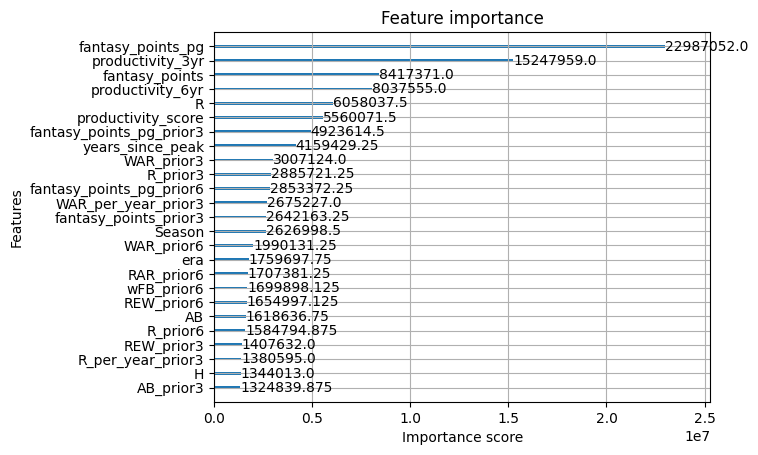

In [12]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [13]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  \
1188     David Wright                 1805.0               1656.440796   
1133   Bobby Witt Jr.                 1834.0               1650.508667   
715    Alex Rodriguez                 2062.0               1640.789795   
171    Prince Fielder                 1826.0               1635.393433   
41        Aaron Judge                 1185.0               1633.754639   
...               ...                    ...                       ...   
578      Chance Sisco                  214.0                108.436302   
1214  Grayson Greiner                   89.0                 93.953590   
669       Pat Valaika                  289.0                 92.078804   
1354     Tim Locastro                  187.0                 87.089989   
714      Andrew Knapp                  187.0                 63.142159   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1188      -148.559204     148.559204    2006   23            1587  
1133      -183.491333     183.491333    2023   23            1594  
715       -421.210205     421.210205    2006   30            1648  
171       -190.606567     190.606567    2008   24            1500  
41         448.754639     448.754639    2022   30            1992  
...               ...            ...     ...  ...             ...  
578       -105.563698     105.563698    2019   24             373  
1214         4.953590       4.953590    2019   26             297  
669       -196.921196     196.921196    2019   26             123  
1354       -99.910011      99.910011    2019   26             498  
714       -123.857841     123.857841    2019   27             231  

[1590 rows x 8 columns]

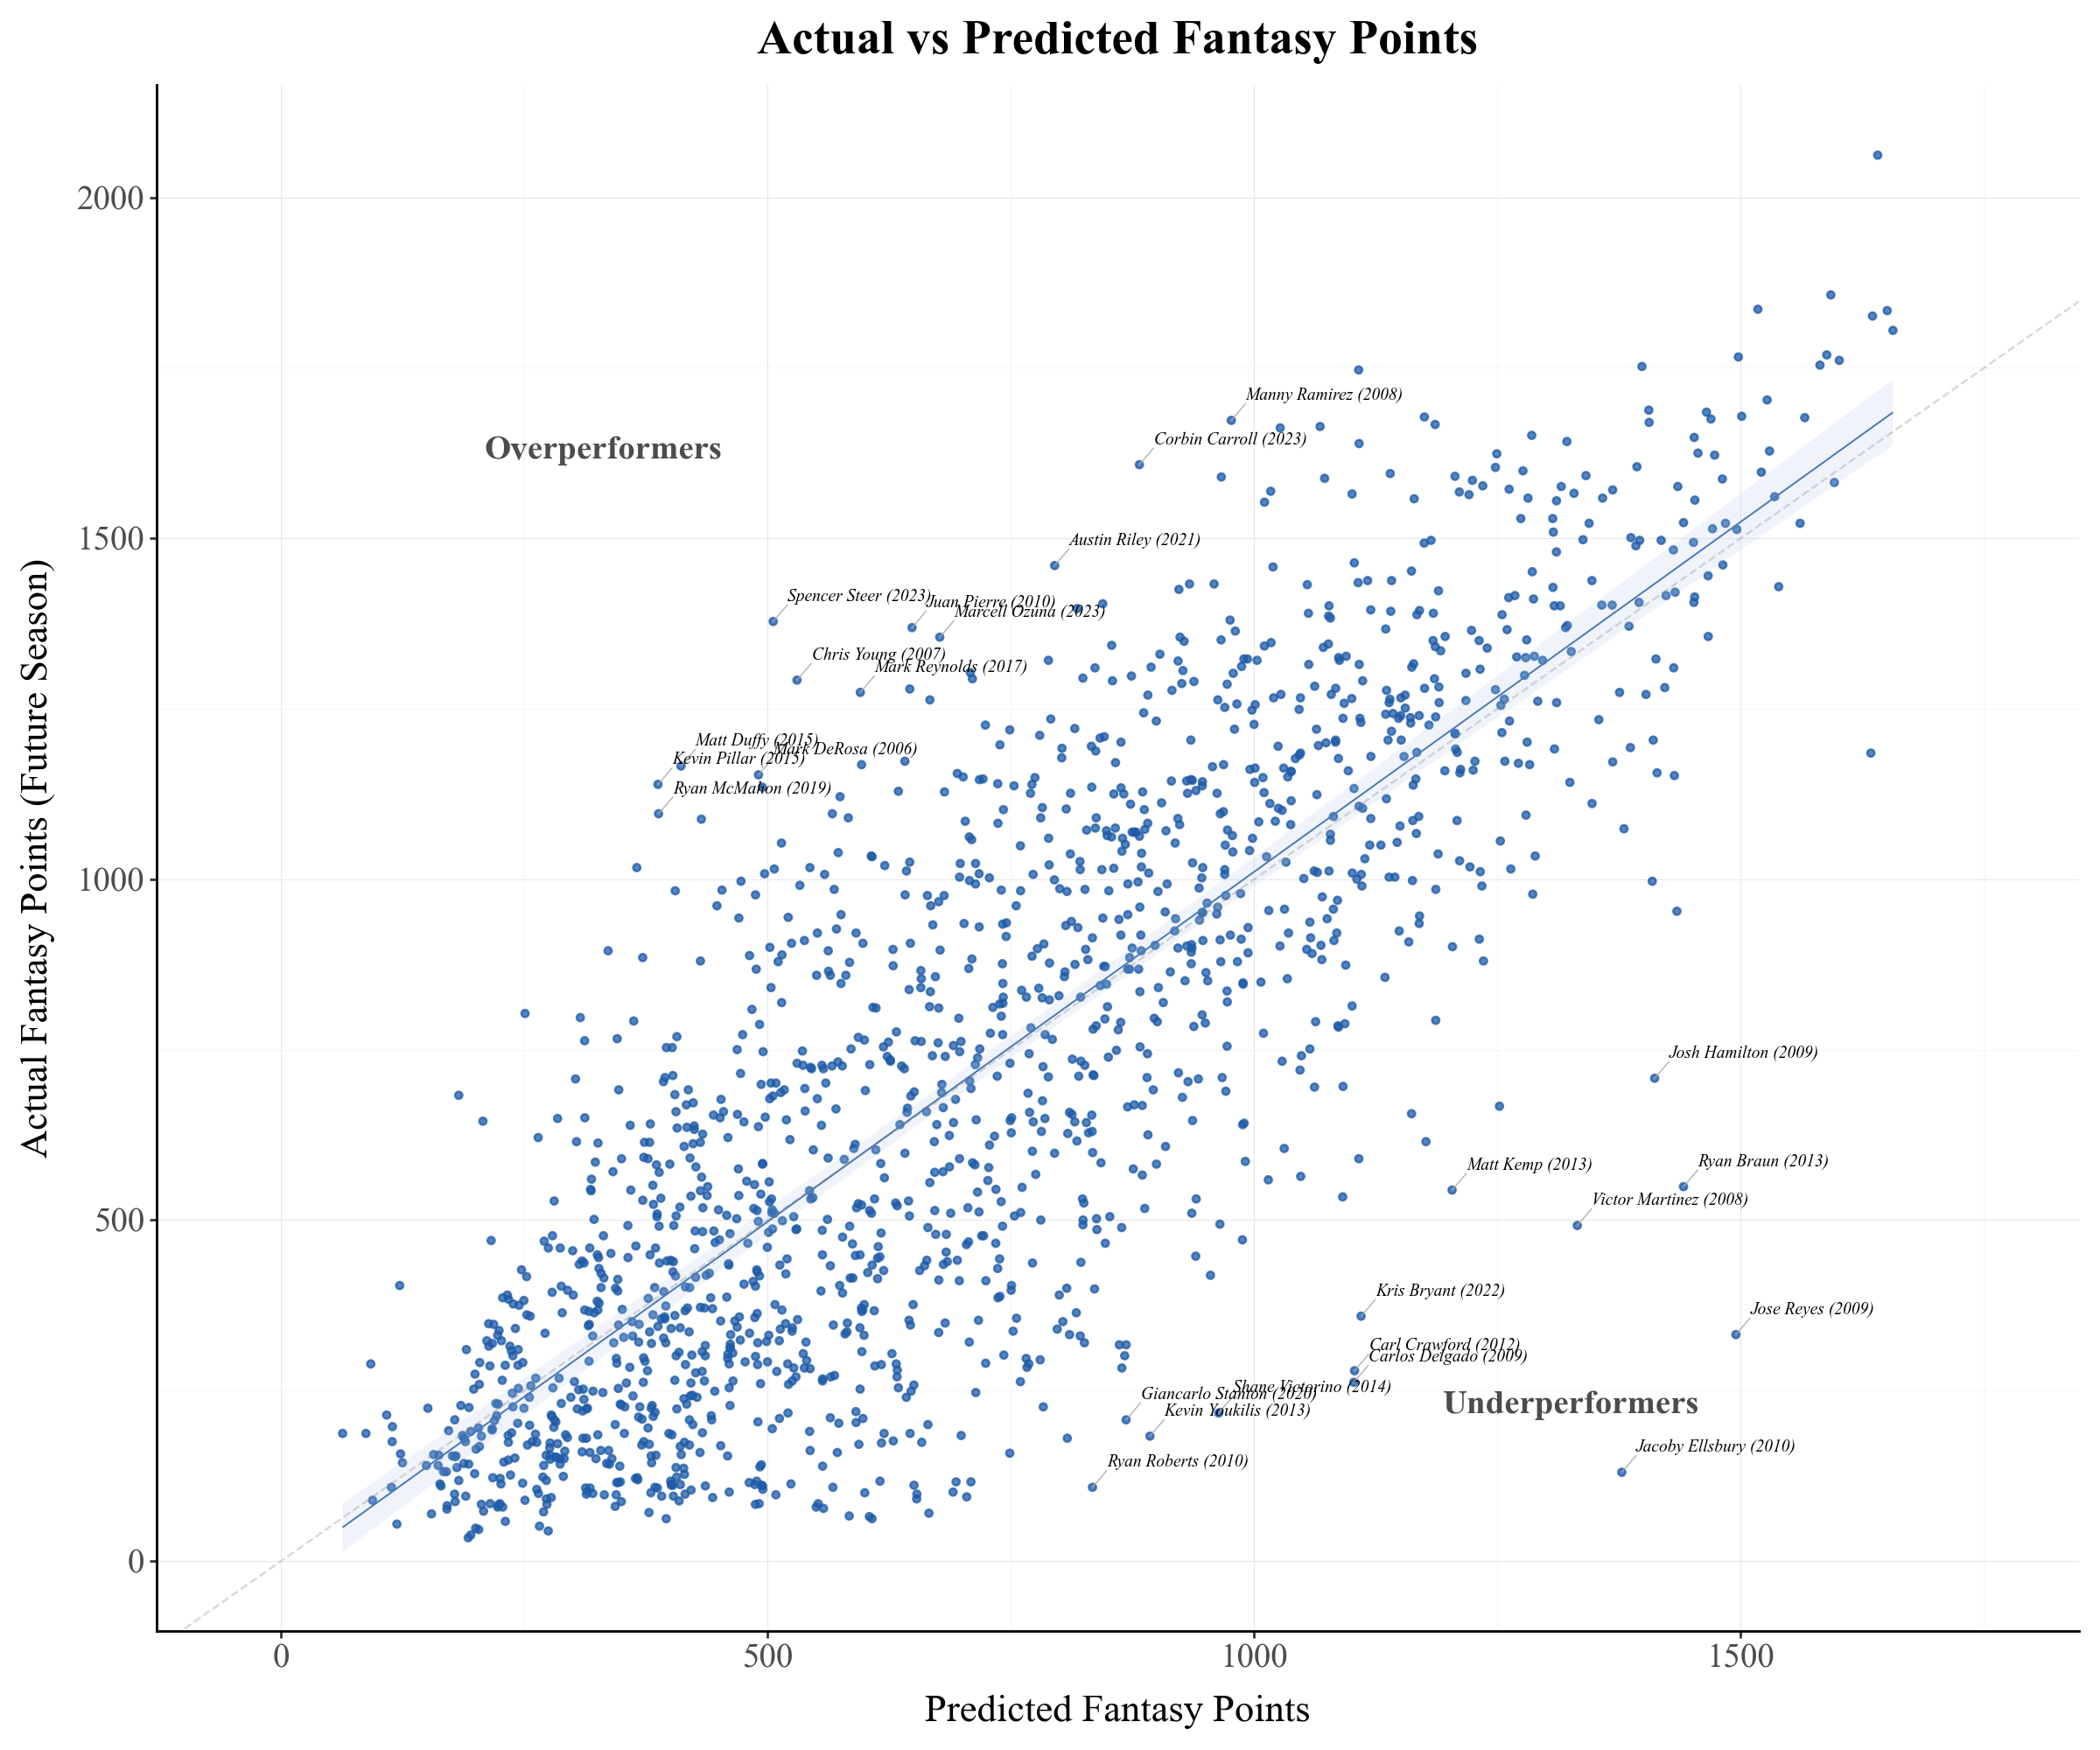

In [14]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

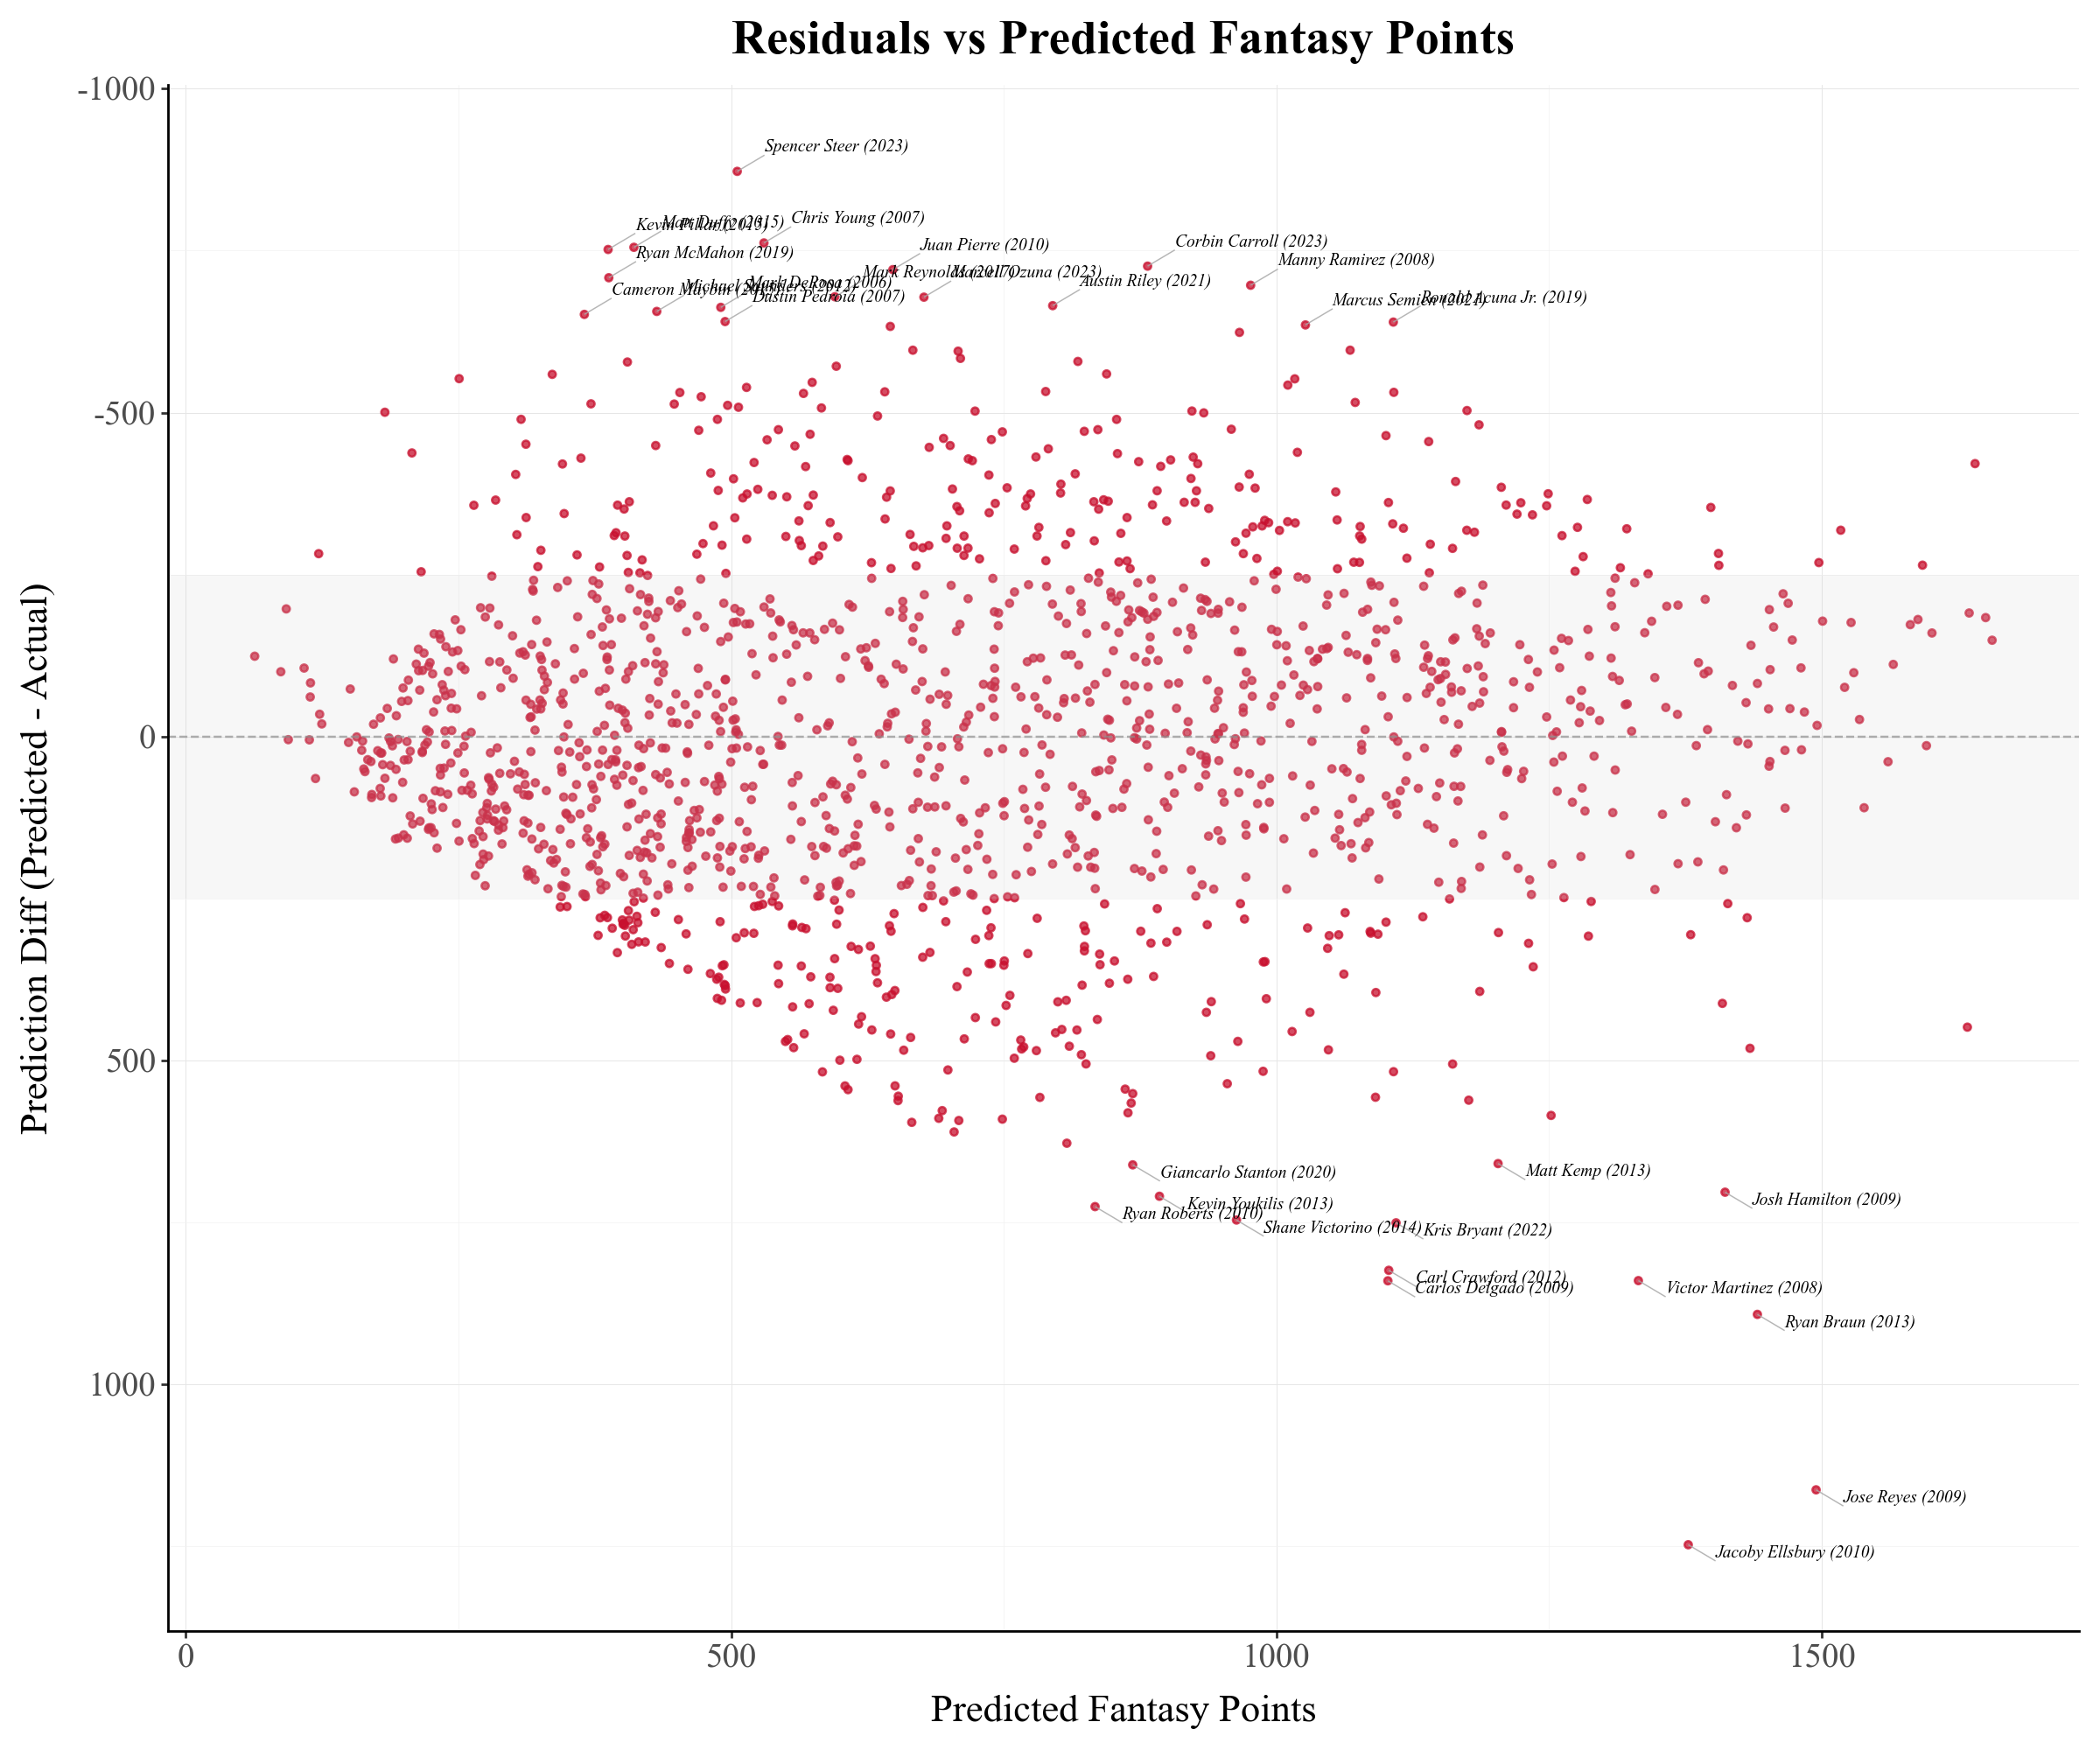

In [15]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

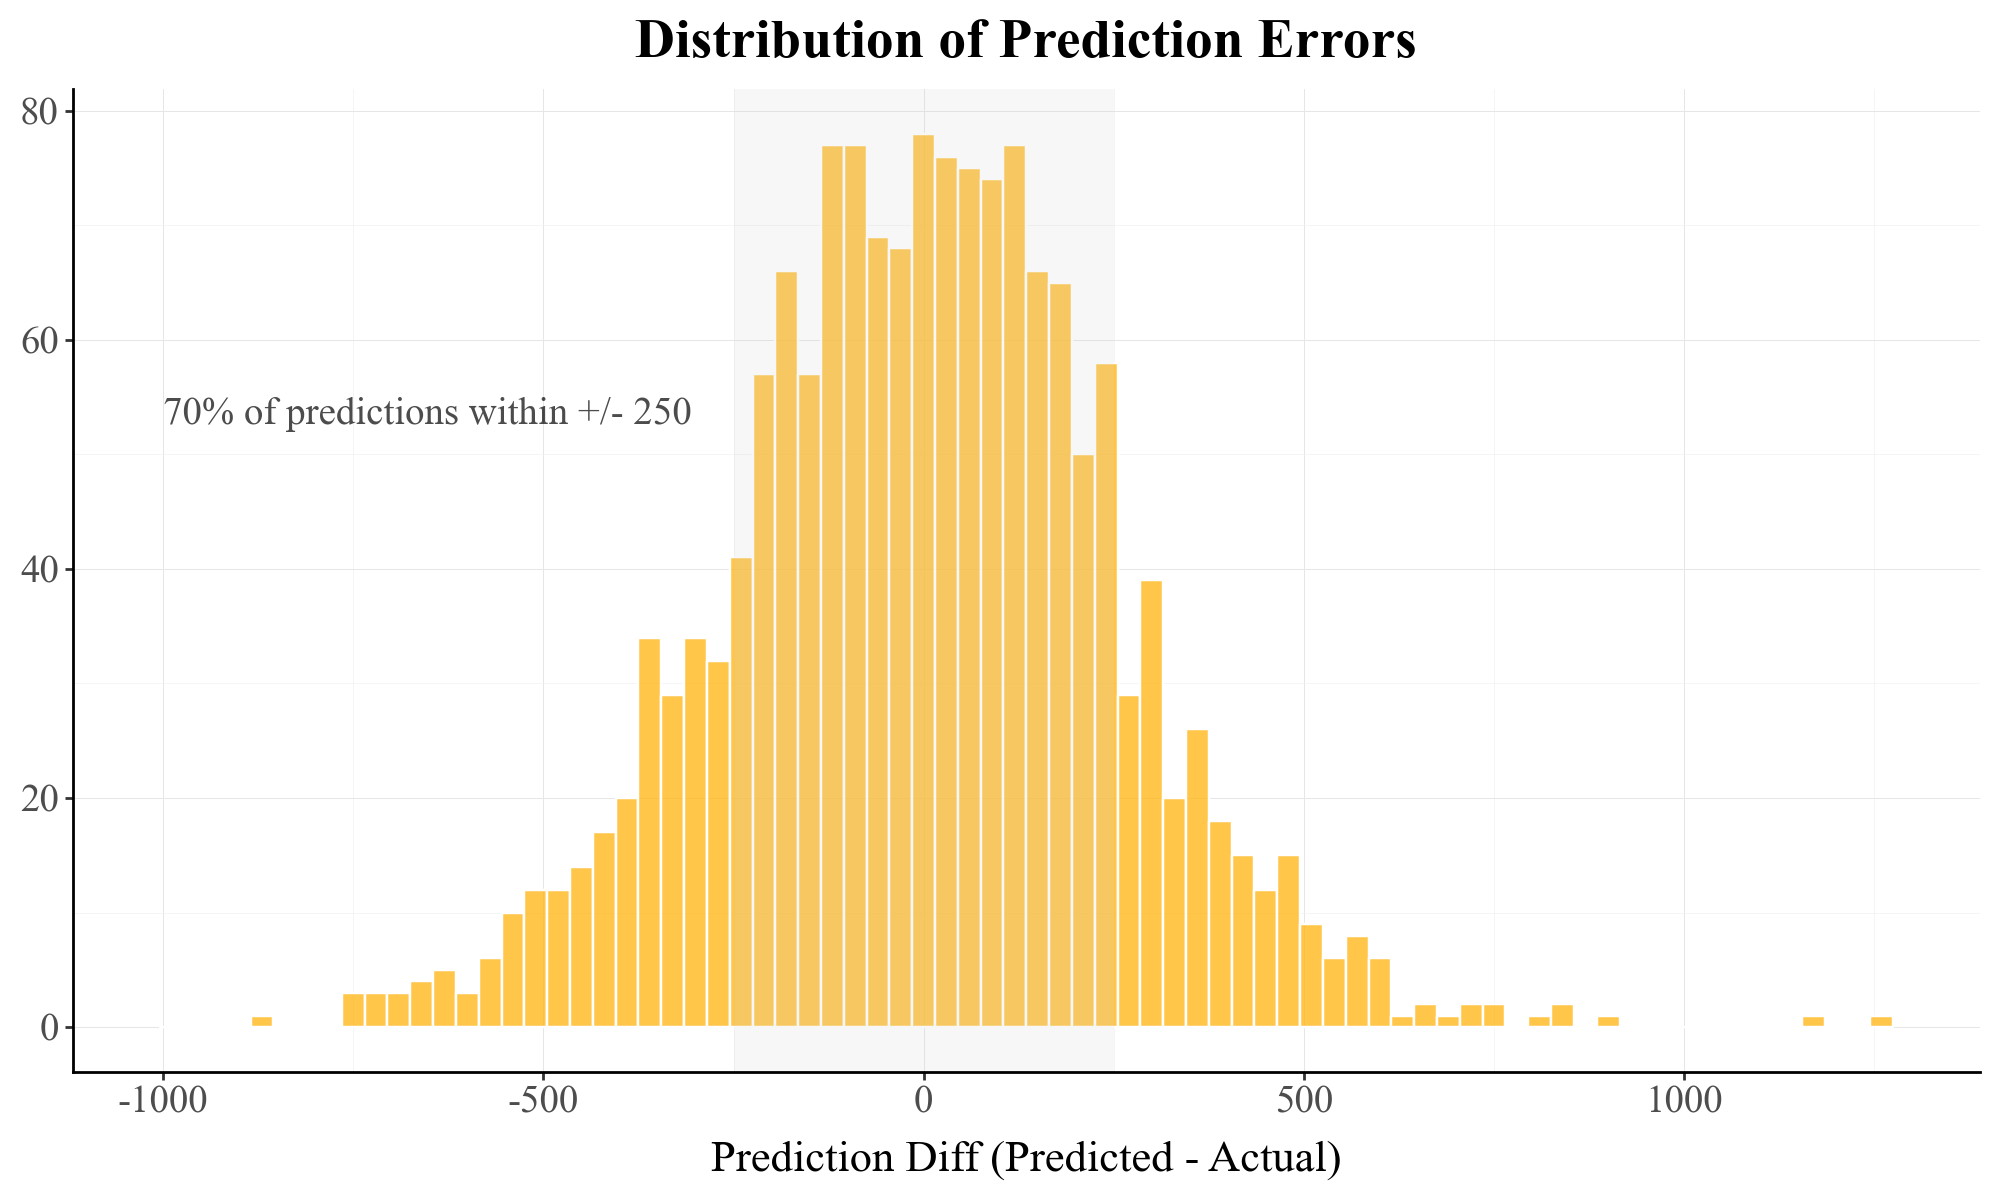

In [16]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

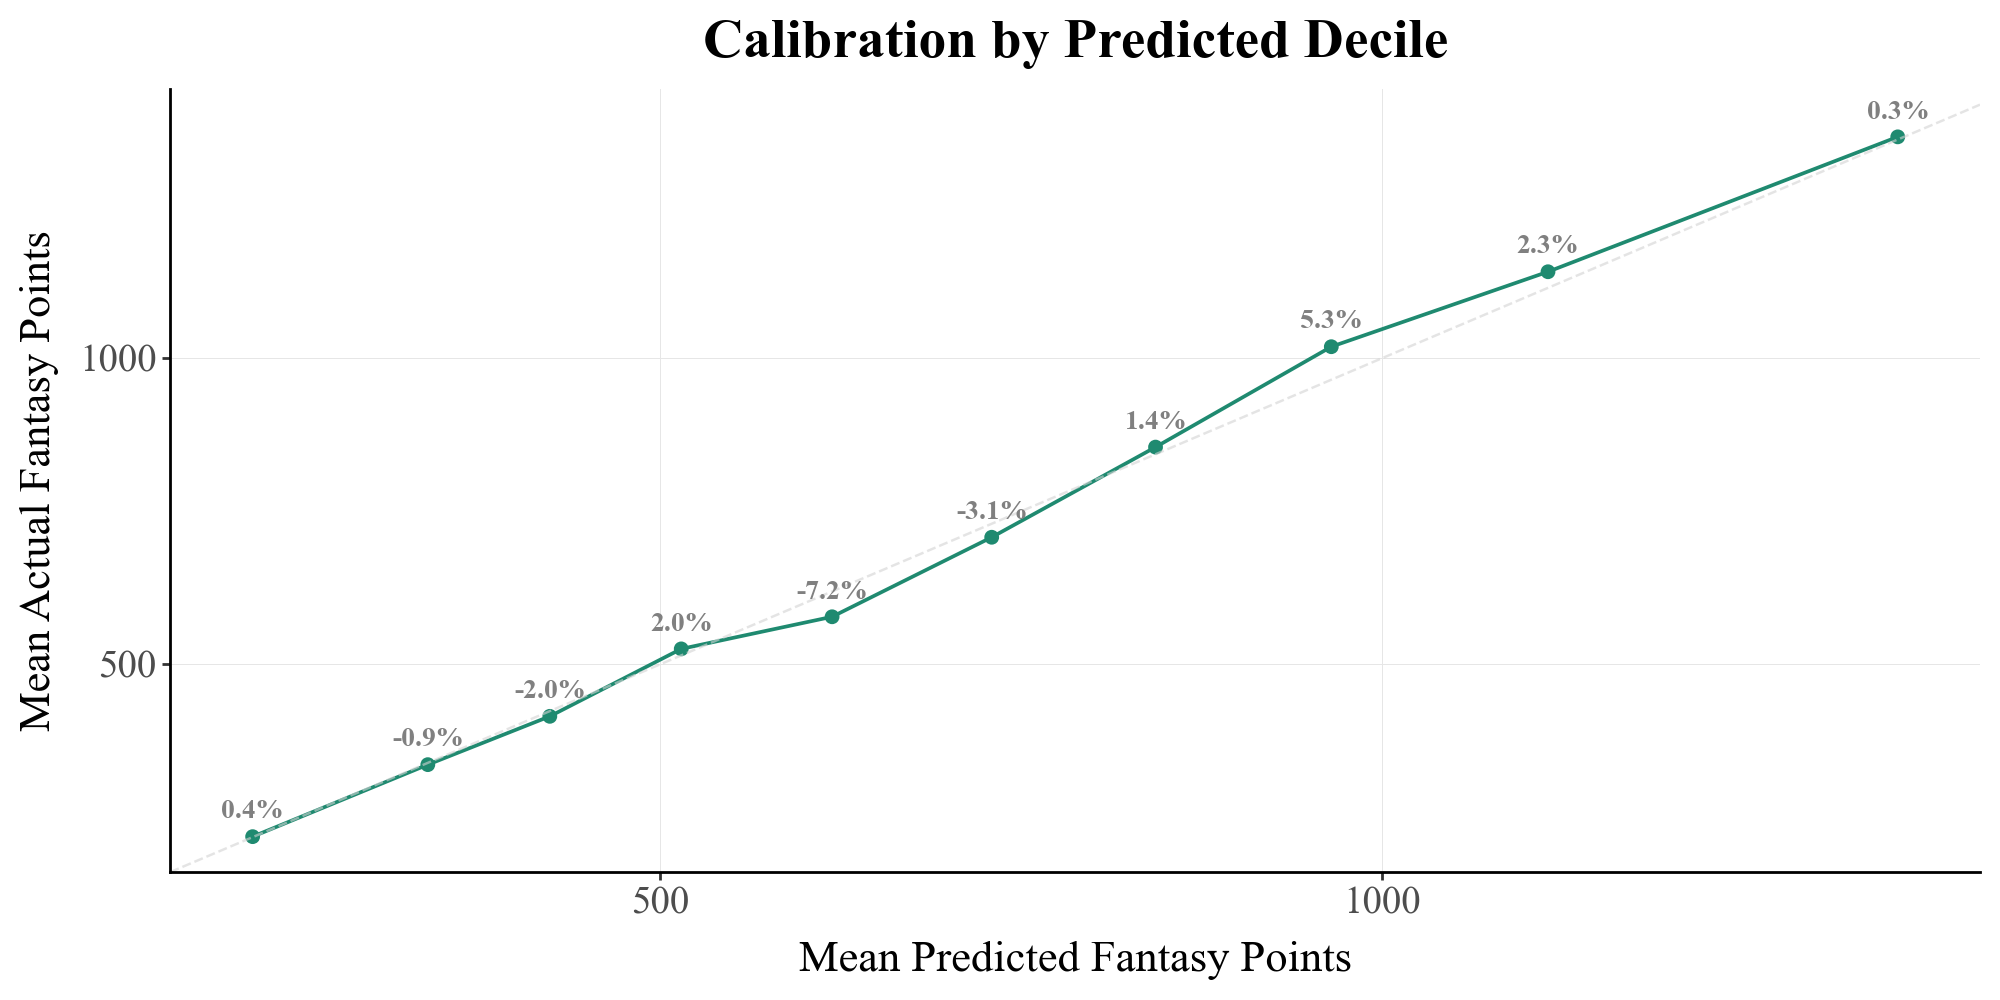

In [17]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [18]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df, random_state=42022)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 170.349 | MAE: 125.951 | R^2: 0.633


In [19]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
980      Max Scherzer                 1464.6               1251.600098   
685   Felix Hernandez                 1165.6               1248.595459   
1126      CC Sabathia                 1369.0               1248.275513   
410         Cliff Lee                 1309.6               1220.396606   
1209     Max Scherzer                 1411.3               1218.608887   
...               ...                    ...                       ...   
408      Austin Adams                   45.3                 73.689674   
1323    Cesar Jimenez                  120.0                 35.443817   
1132  Stefan Crichton                  136.0                 34.781750   
386        Ron Flores                   75.6                 34.266537   
189     Kevin Chapman                   97.3                 22.886457   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
980       -212.999902     212.999902    2017   32          1316.6  
685         82.995459      82.995459    2010   24          1319.6  
1126      -120.724487     120.724487    2007   26          1187.0  
410        -89.203394      89.203394    2010   31          1026.3  
1209      -192.691113     192.691113    2015   30          1369.6  
...               ...            ...     ...  ...             ...  
408         28.389674      28.389674    2015   28           136.3  
1323       -84.556183      84.556183    2014   29            63.0  
1132      -101.218250     101.218250    2019   27           158.3  
386        -41.333463      41.333463    2006   26           119.6  
189        -74.413543      74.413543    2013   25            98.3  

[1525 rows x 8 columns]

# Pitching Predictions

In [20]:
# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=45,
    random_state=42020,
    id_cols=["IDfg"],
    max_depth_choices=None,
)

100%|██████████| 45/45 [05:15<00:00,  7.00s/trial, best loss: 172.29085141118978]
Best Parameters: {'learning_rate': 0.07745213706165138, 'max_leaves': 14, 'grow_policy': 'lossguide', 'max_depth': 0, 'subsample': 0.8559687254552908, 'colsample_bytree': 0.9782667317494186, 'min_child_weight': 0.661578804473453, 'reg_lambda': 5.02953657881003e-05, 'reg_alpha': 0.09878837851327885, 'gamma': 0.001398952582978997}
[Best trial @ val] optimized=rmse | RMSE=172.291 | MAE=125.992 | ASYM=37242.748


In [21]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202022,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 87
[Val] RMSE: 172.121 | MAE: 126.075 | R^2: 0.627 | ASYM: 37194.182
[Test] RMSE: 166.755 | MAE: 124.258 | R^2: 0.648 | ASYM: 35011.413


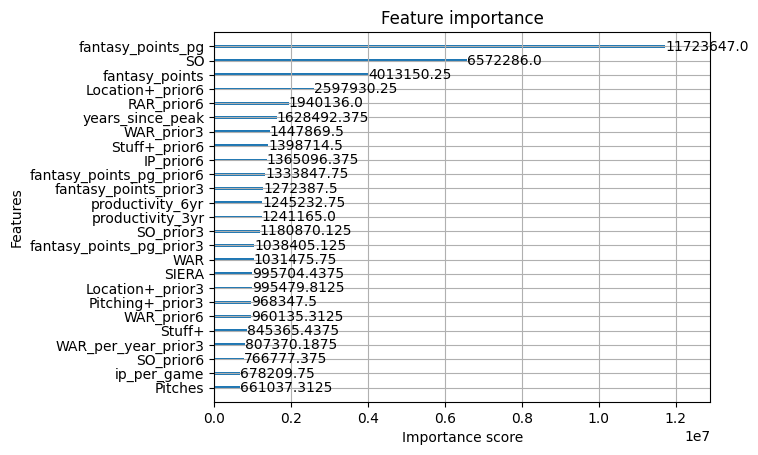

In [22]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [23]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  \
1126        CC Sabathia                 1369.0               1239.844482   
1104    Felix Hernandez                 1193.0               1216.783691   
650         Gerrit Cole                 1537.3               1213.181885   
950    Justin Verlander                 1422.0               1201.530396   
685     Felix Hernandez                 1165.6               1190.756104   
...                 ...                    ...                       ...   
877       Kohei Arihara                   44.0                 92.612198   
1509        Tyler Zuber                   99.3                 87.277443   
1158         Brad Mills                   53.3                 82.629906   
816   Elieser Hernandez                  155.6                 67.527725   
1160       Cody Stashak                   86.0                 54.226608   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1126      -129.155518     129.155518    2007   26          1187.0  
1104        23.783691      23.783691    2011   25          1165.6  
650       -324.118115     324.118115    2018   27          1311.3  
950       -220.469604     220.469604    2010   27          1167.3  
685         25.156104      25.156104    2010   24          1319.6  
...               ...            ...     ...  ...             ...  
877         48.612198      48.612198    2021   28           112.6  
1509       -12.022557      12.022557    2020   25           131.0  
1158        29.329906      29.329906    2010   25            83.3  
816        -88.072275      88.072275    2019   24           378.3  
1160       -31.773392      31.773392    2019   25           123.0  

[1525 rows x 8 columns]

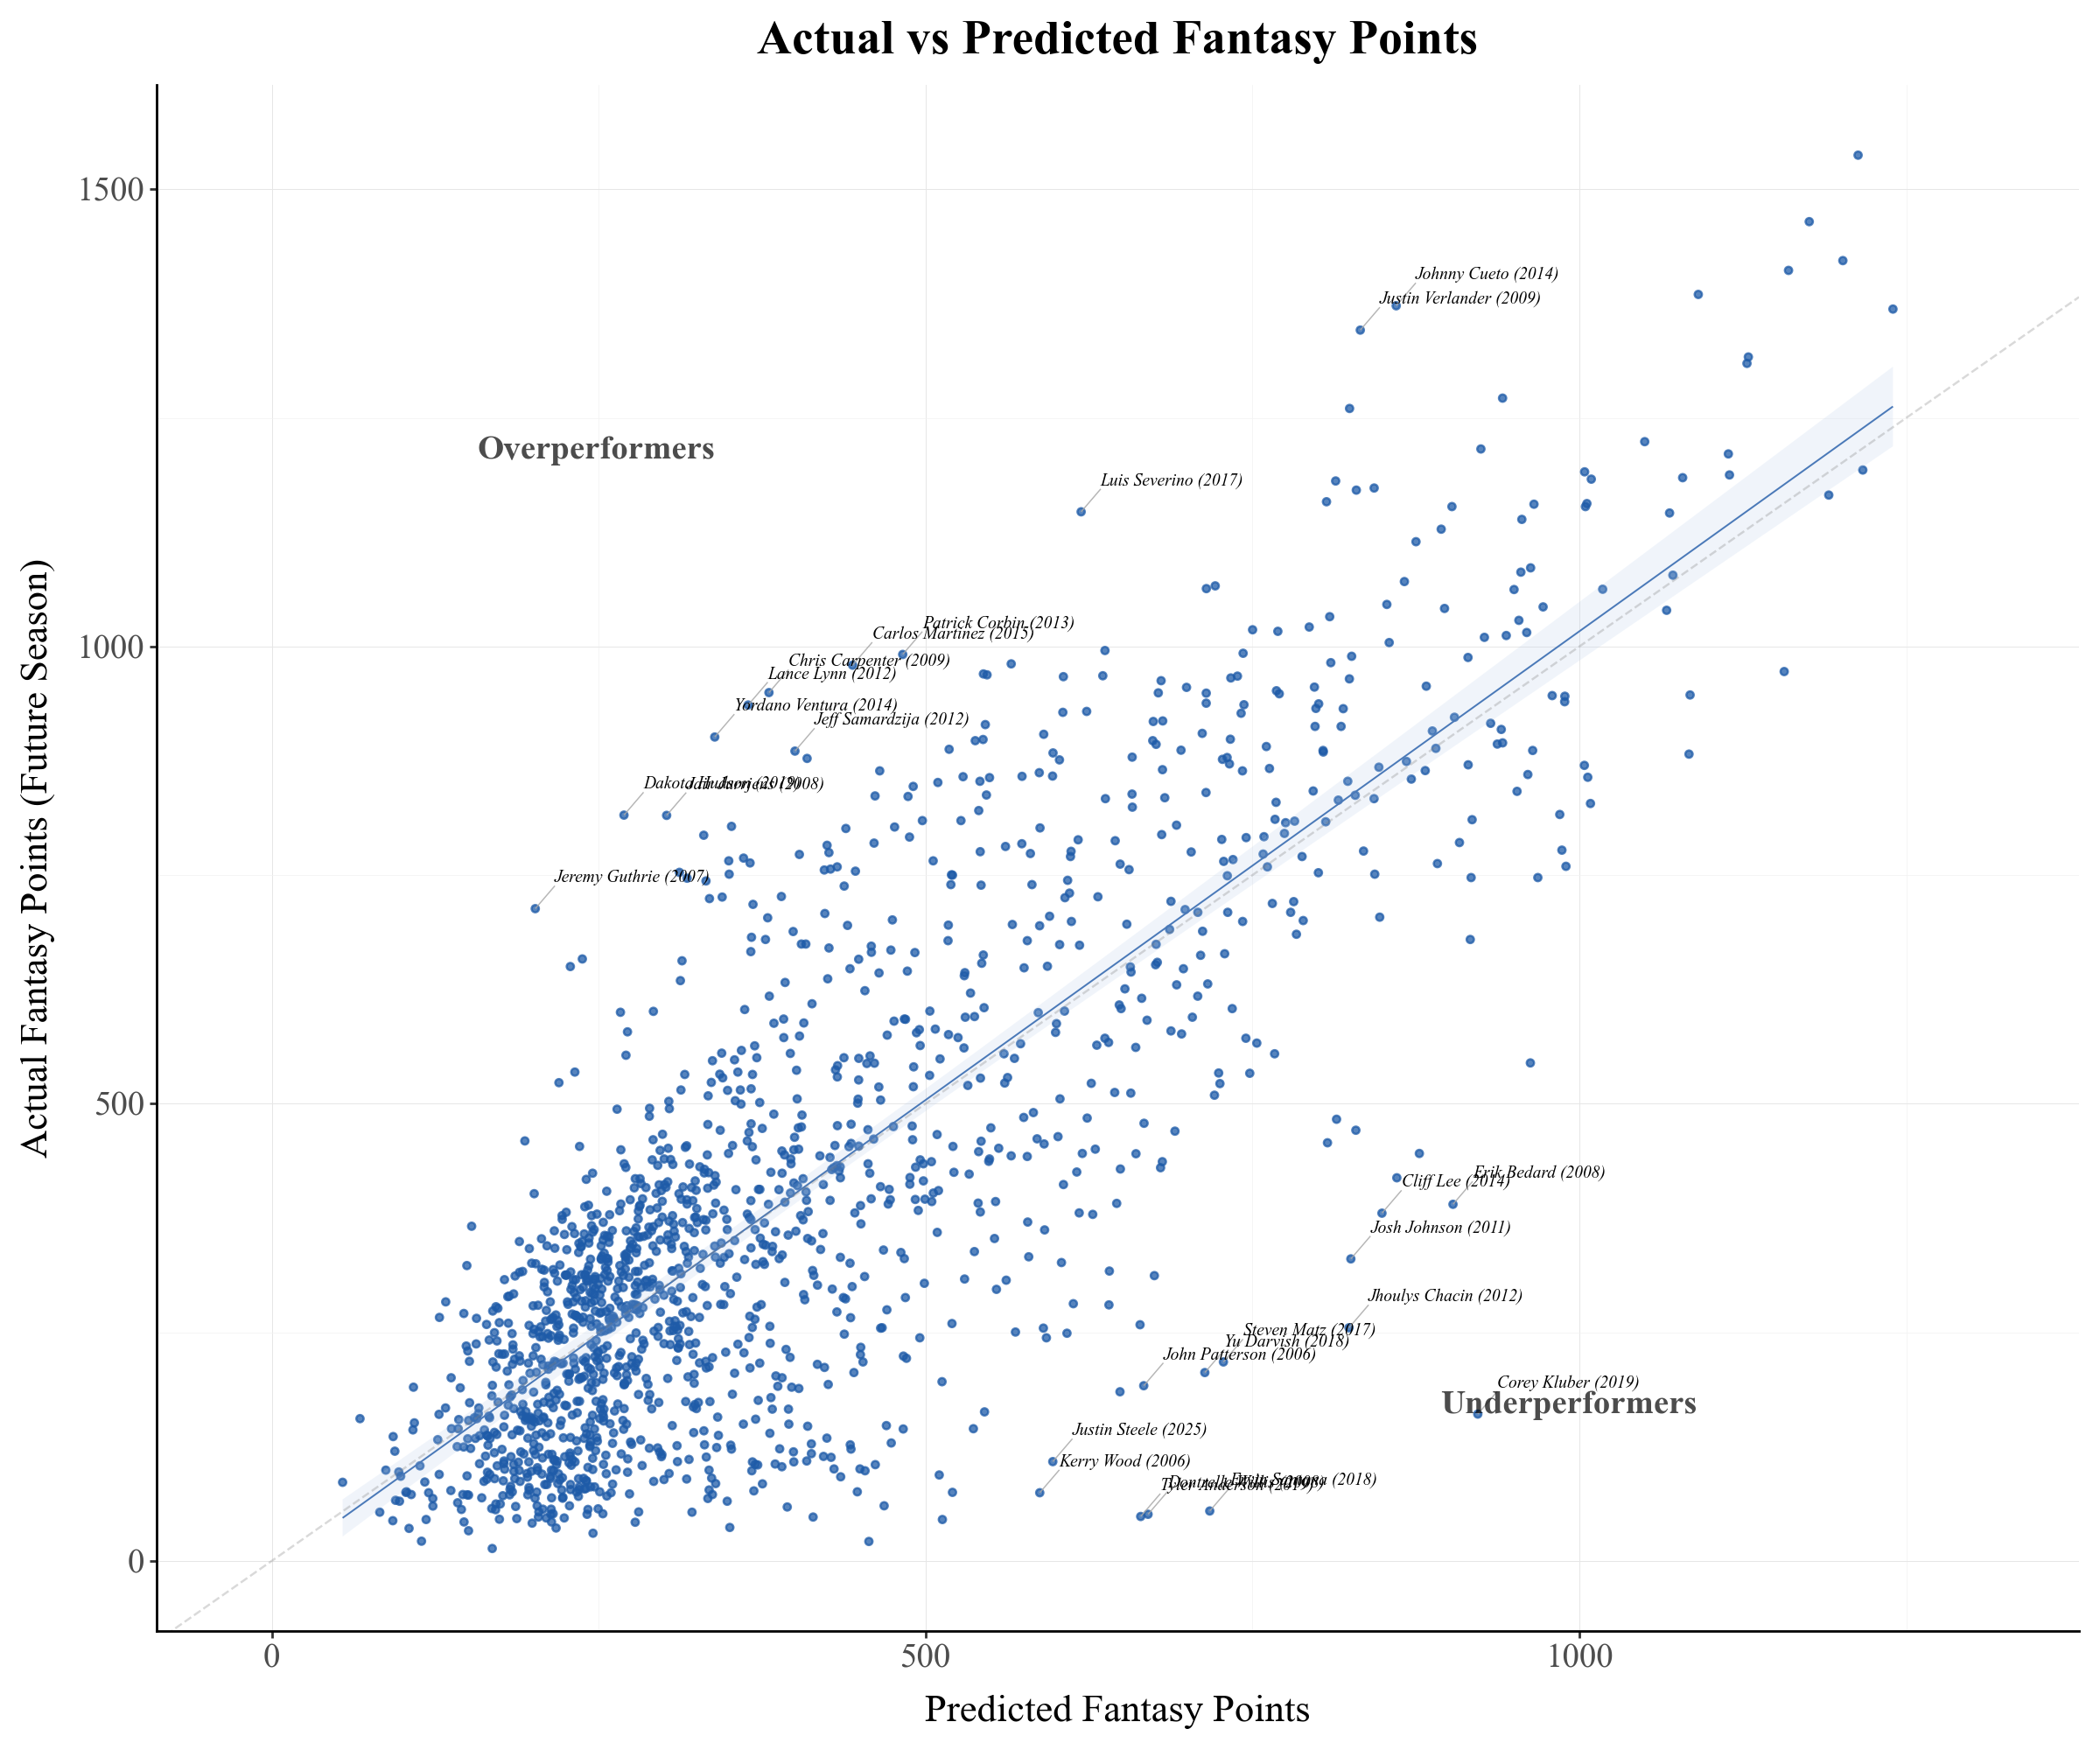

In [24]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

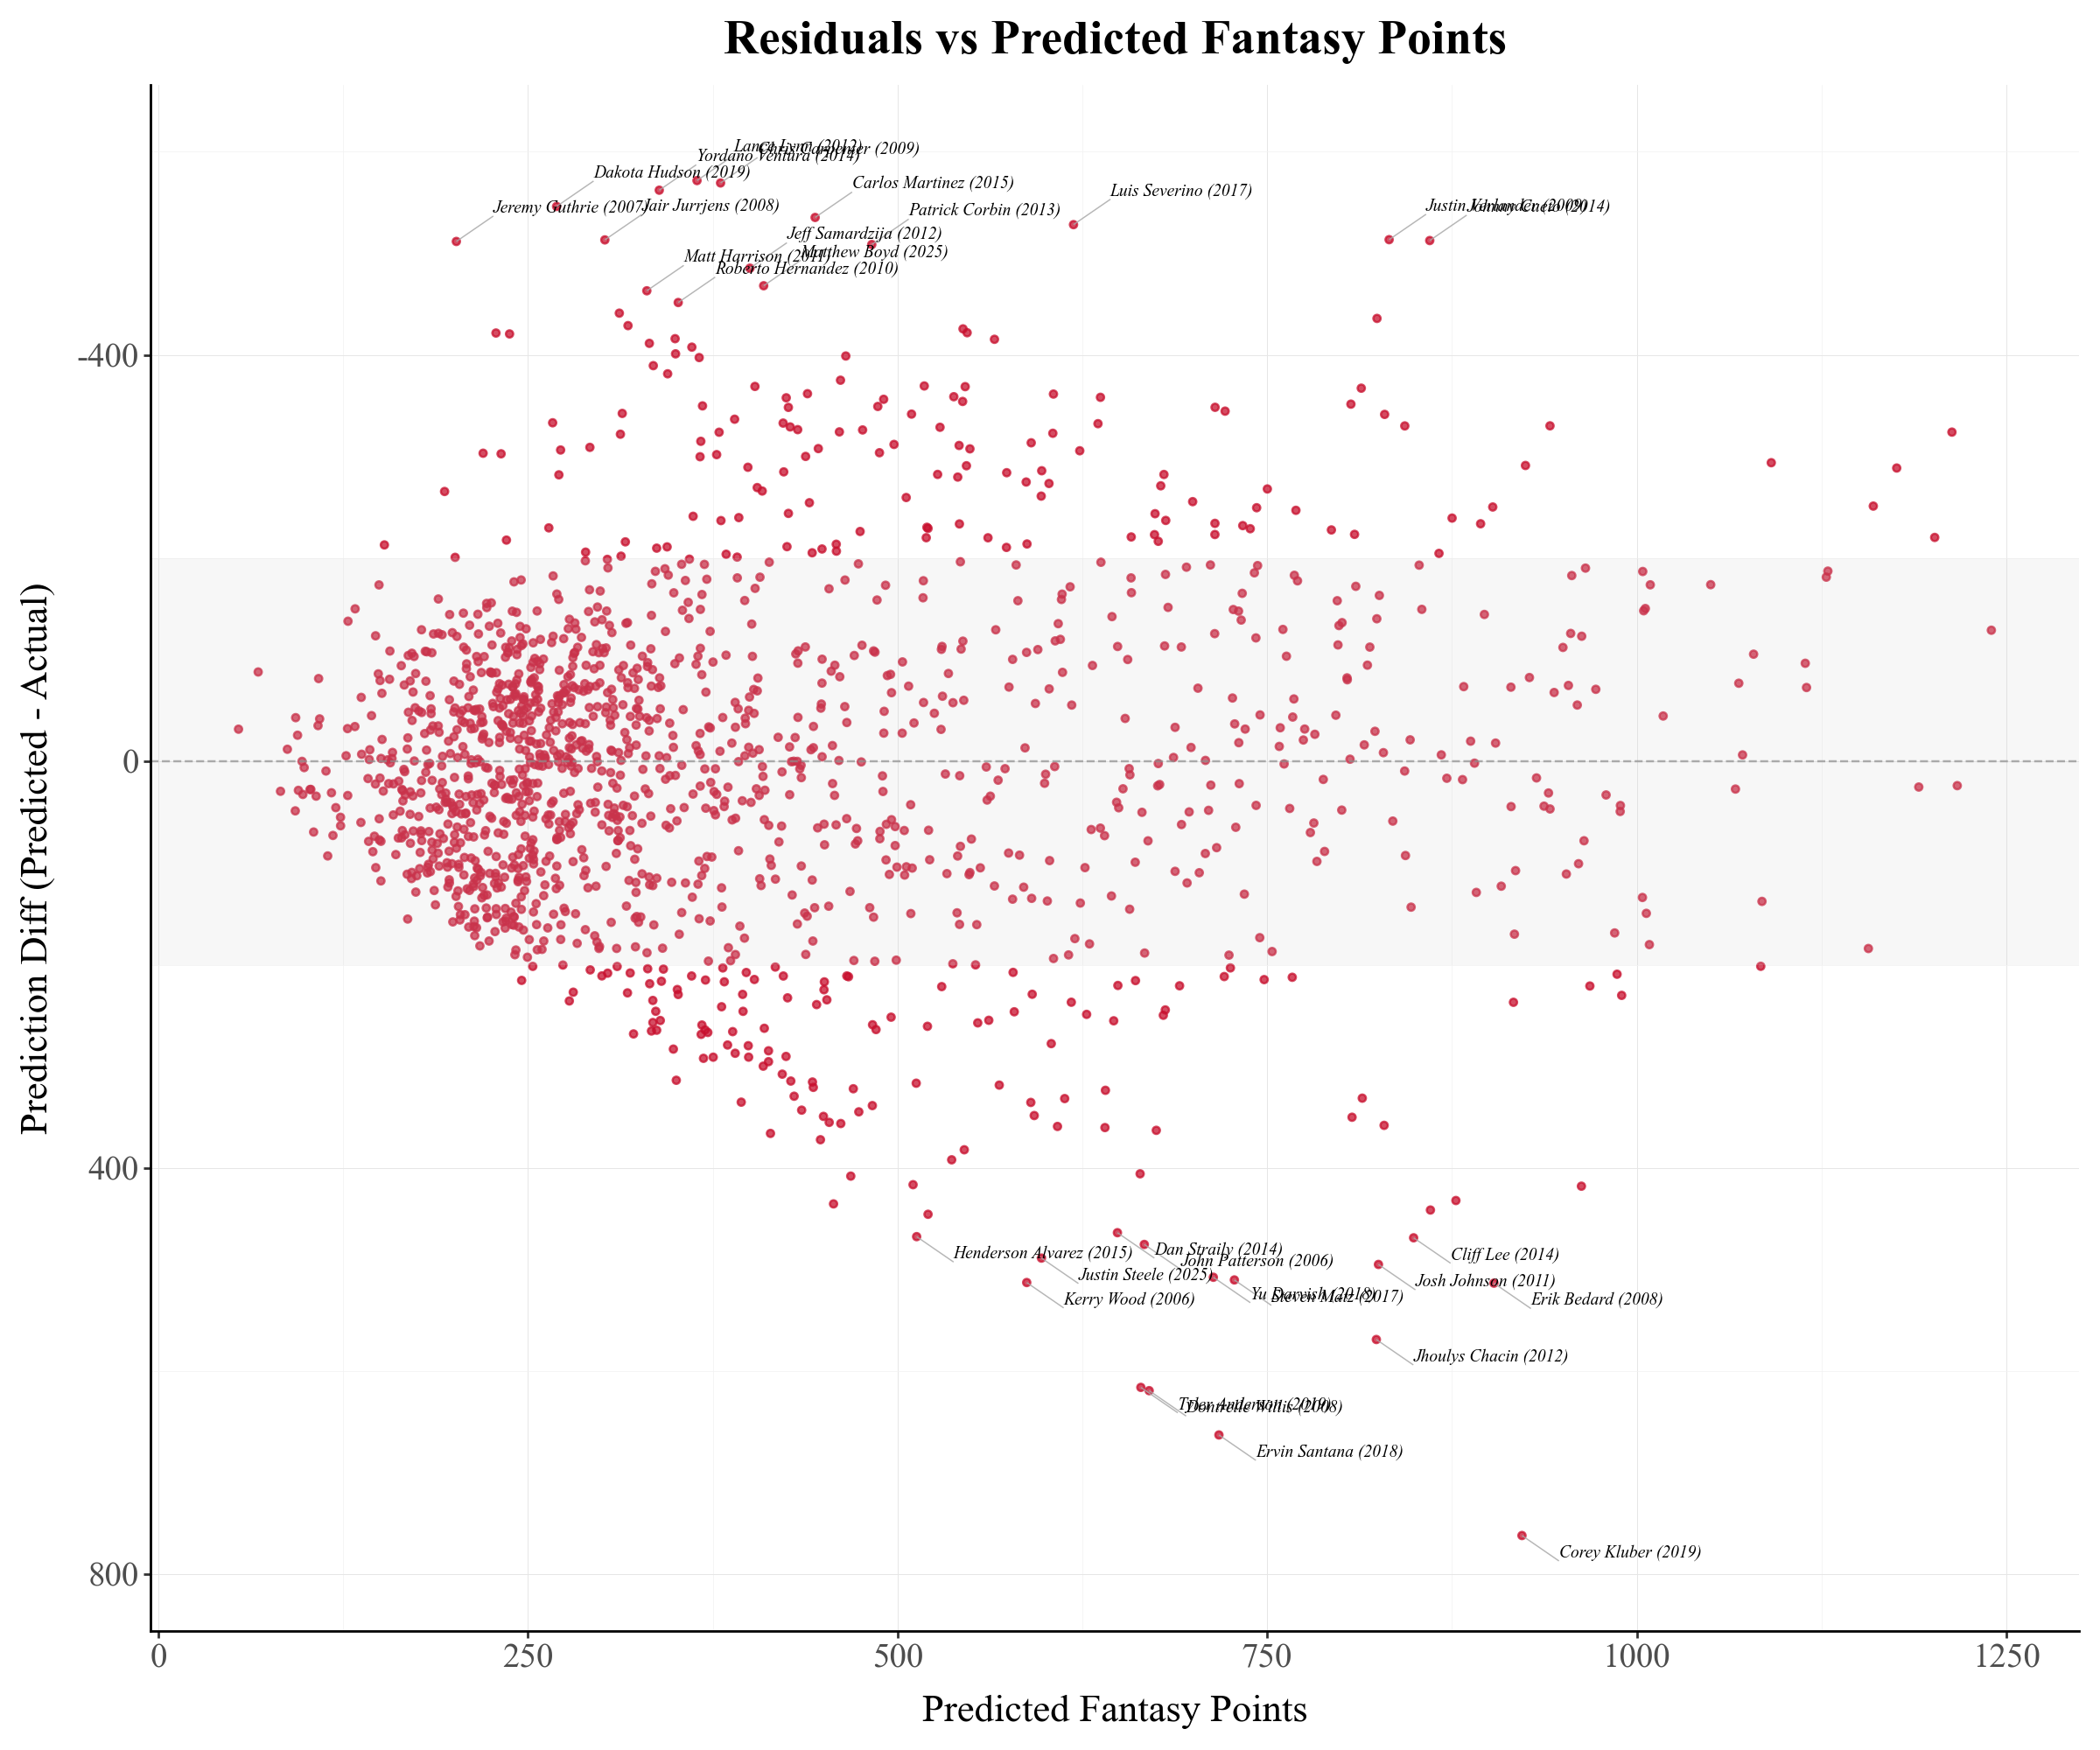

In [25]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

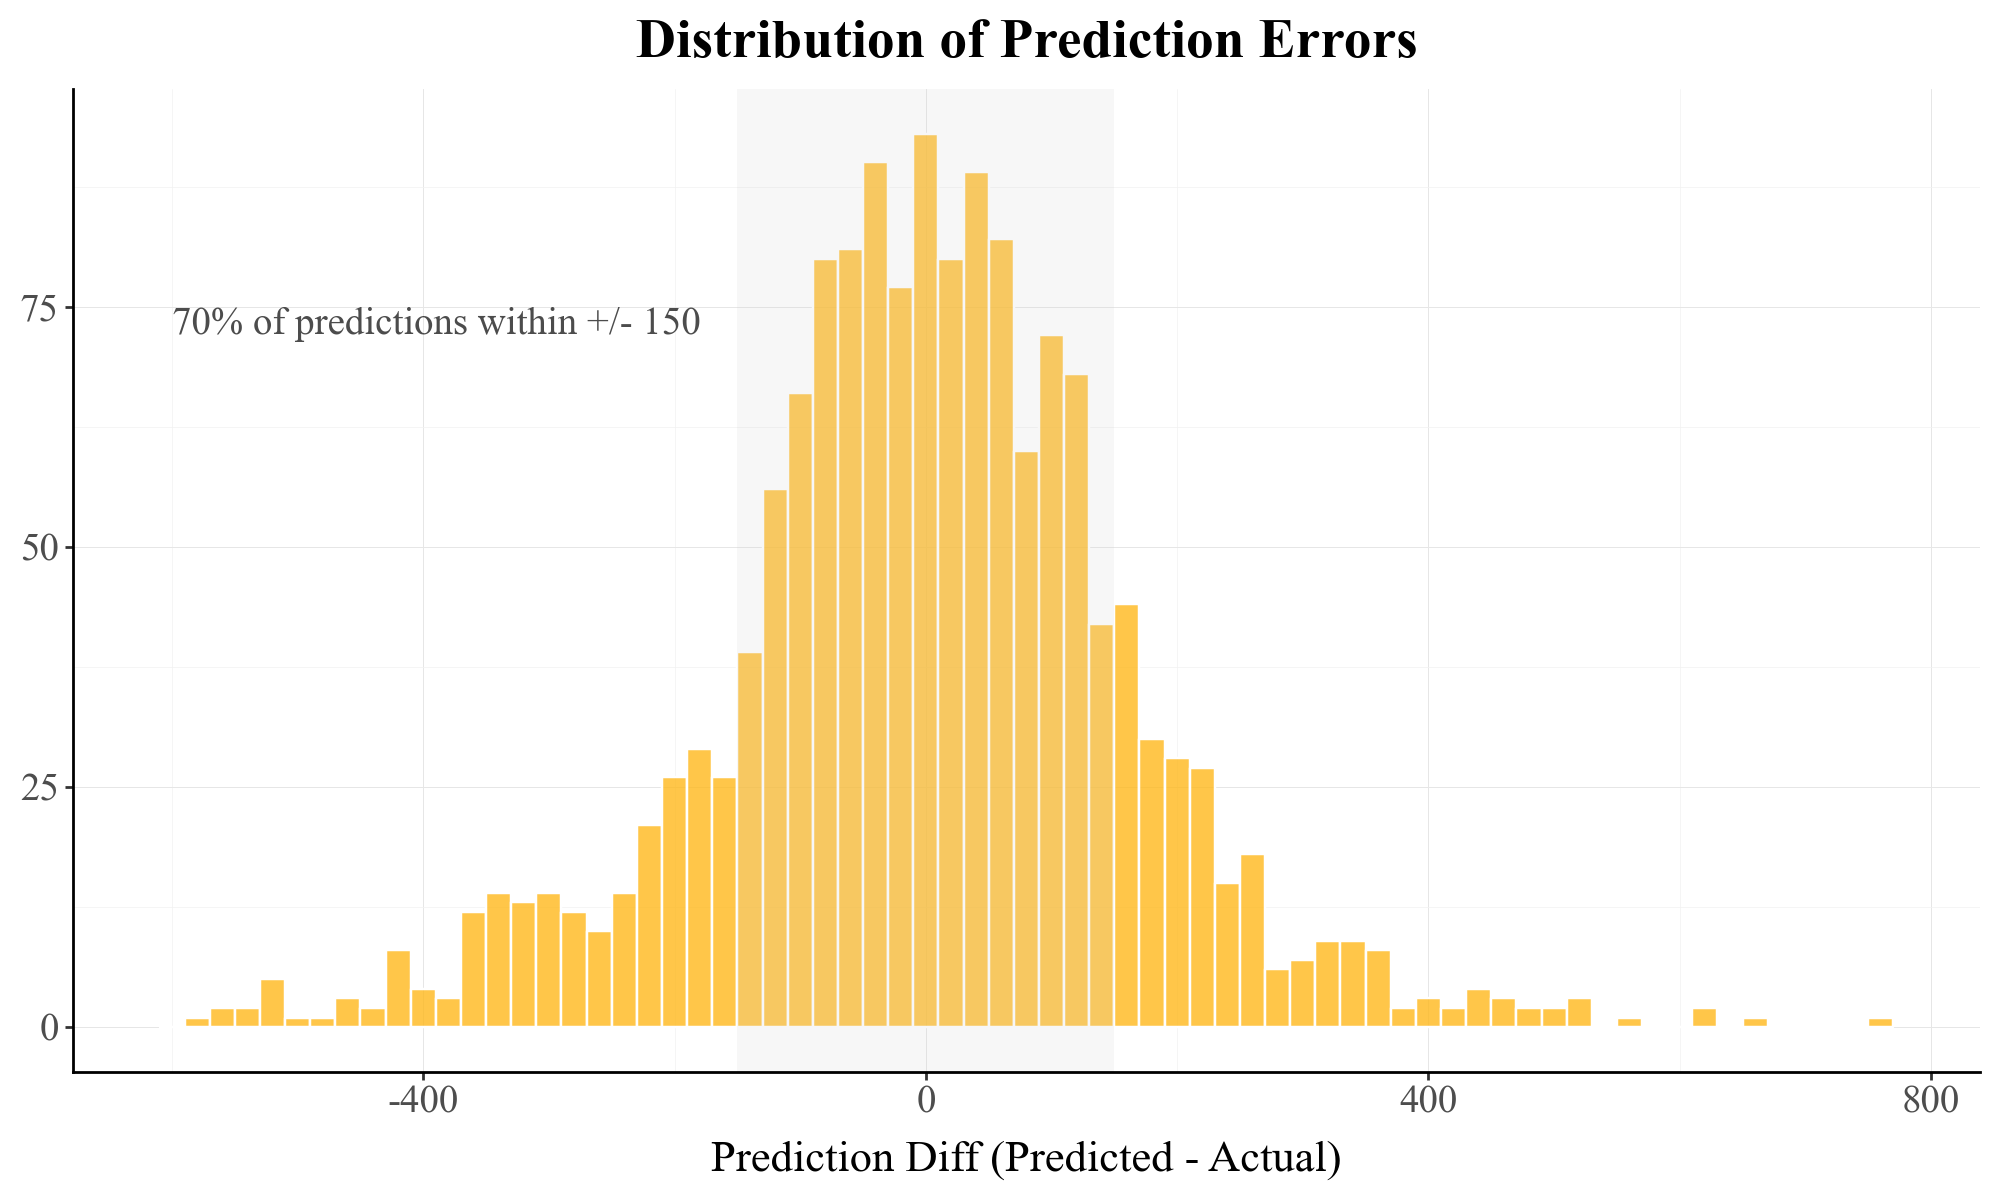

In [26]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=20,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

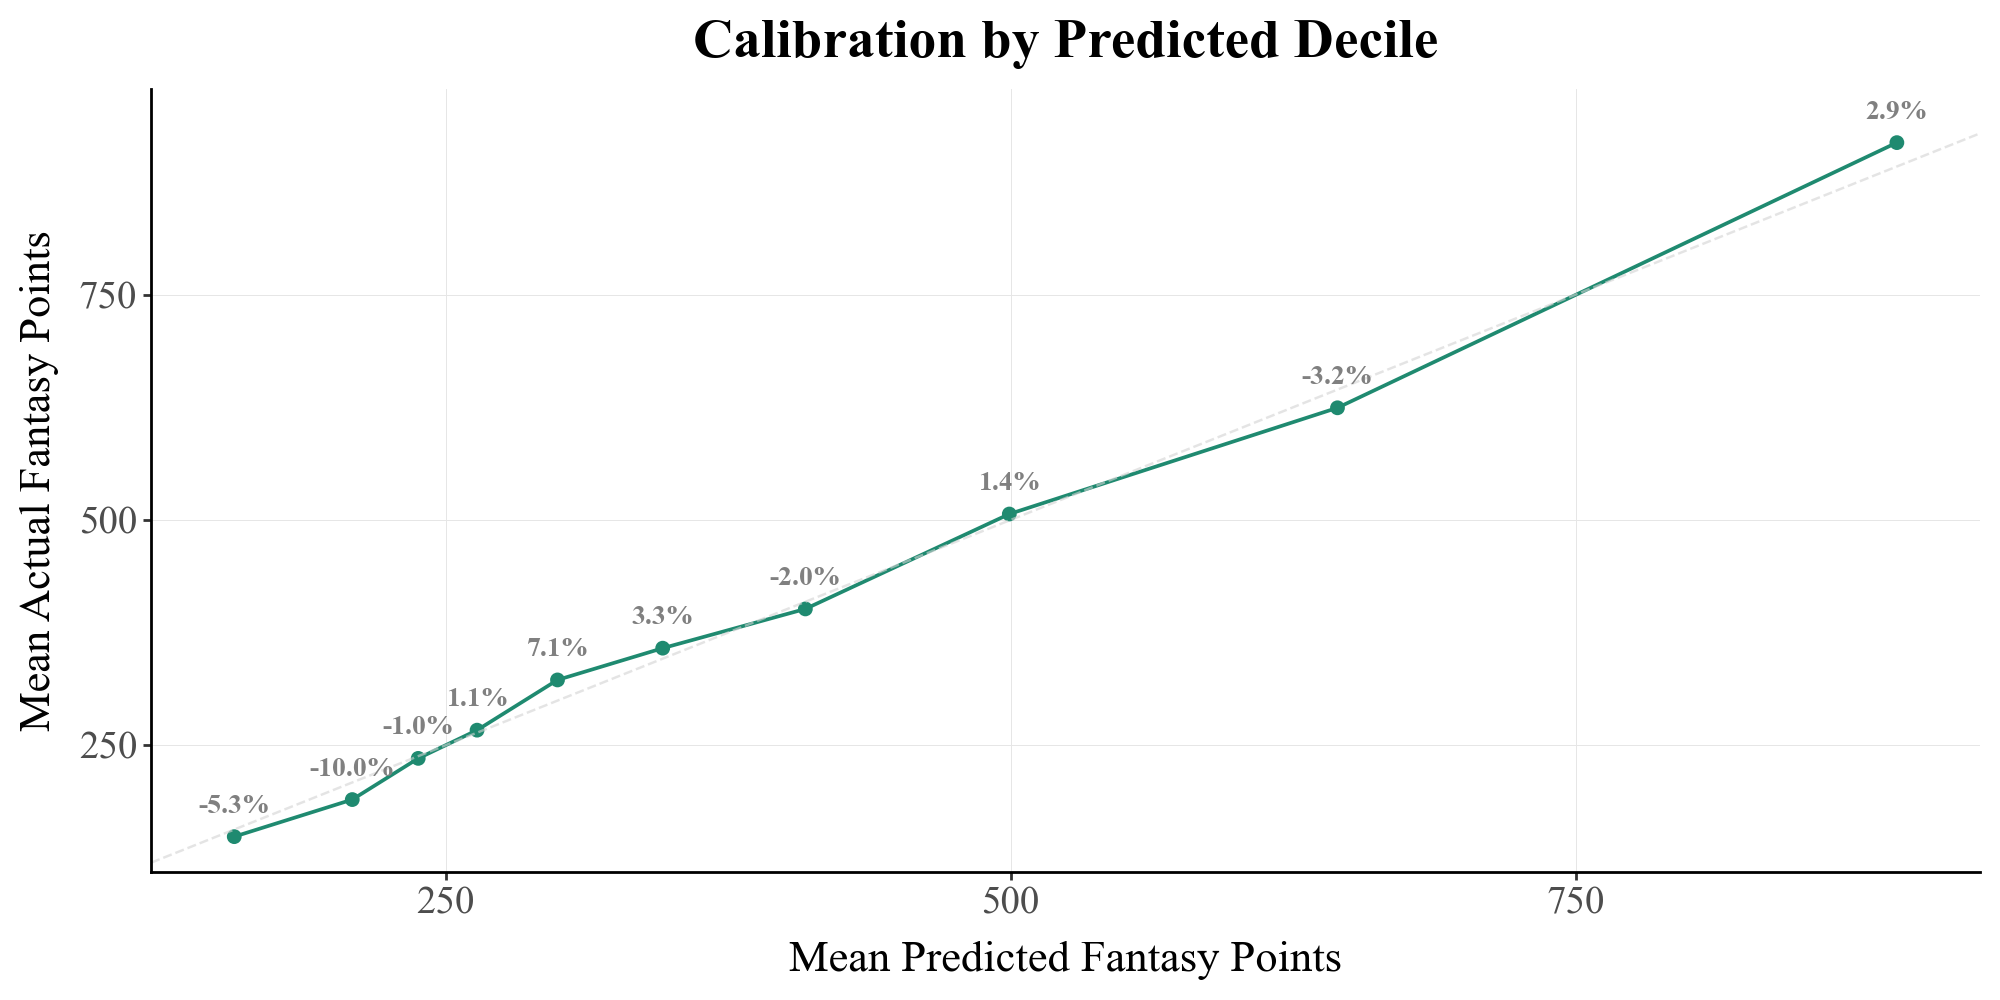

In [27]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [28]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_predictions = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

In [29]:
batting_pred['fantasy_points_pred'] = batting_predictions
pitching_pred['fantasy_points_pred'] = pitching_predictions

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [30]:
display(batting_pred)

IDfg  Season             Name  Age    G   AB    H   1B  2B  3B  ...  \
10328  19755    2025    Shohei Ohtani   30  158  611  172   83  25   9  ...   
9180   15640    2025      Aaron Judge   33  152  541  179   94  30   2  ...   
10491  20123    2025        Juan Soto   26  160  577  152   88  20   1  ...   
9457   16478    2025   Kyle Schwarber   32  162  604  145   64  23   2  ...   
10885  23697    2025  Julio Rodriguez   24  160  652  174  107  31   4  ...   
...      ...     ...              ...  ...  ...  ...  ...  ...  ..  ..  ...   
11366  31661    2025     Jacob Melton   24   32   70   11   10   0   1  ...   
11031  25779    2025    Tyler Tolbert   27   64   50   14   11   2   0  ...   
11301  29704    2025  Braxton Fulford   26   38  108   23   15   5   2  ...   
11221  27653    2025   Christian Koss   27   76  174   46   34   9   0  ...   
10997  25434    2025      Will Wilson   26   34   78   15   11   4   0  ...   

       H_per_year_prior3  HR_per_year_prior3  SB_per_year_prior3  \
10328         173.333333                51.0                33.0   
9180          152.333333           49.333333            8.333333   
10491              158.0           39.666667                19.0   
9457               134.0                47.0                 5.0   
10885         169.666667                28.0           30.333333   
...                  ...                 ...                 ...   
11366               11.0                 0.0                 7.0   
11031               14.0                 1.0                21.0   
11301               23.0                 1.0                 1.0   
11221               46.0                 3.0                 4.0   
10997               15.0                 0.0                 2.0   

       BB_per_year_prior3  SO_per_year_prior3  WAR_per_year_prior3  \
10328           93.666667               164.0             7.666667   
9180                115.0          153.666667             8.733333   
10491          129.333333          128.333333             6.766667   
9457           113.333333               203.0             3.033333   
10885                43.0               161.0             5.166667   
...                   ...                 ...                  ...   
11366                 6.0                29.0                 -0.3   
11031                 1.0                11.0                  0.3   
11301                 7.0                36.0                 -0.5   
11221                 9.0                45.0                  0.5   
10997                 7.0                34.0                 -0.4   

       AB_growth_recent  G_growth_recent  player_tier_recent  \
10328         29.666667         7.333333                star   
9180               52.0        13.333333                star   
10491          3.333333         0.333333                star   
9457          16.666667         4.666667           above_avg   
10885         27.666667         7.333333                star   
...                 ...              ...                 ...   
11366               0.0              0.0         replacement   
11031               0.0              0.0         replacement   
11301               0.0              0.0         replacement   
11221               0.0              0.0         replacement   
10997               0.0              0.0         replacement   

       fantasy_points_pred  
10328          1582.200928  
9180           1545.081543  
10491          1477.096924  
9457           1430.369507  
10885          1415.441040  
...                    ...  
11366           147.857666  
11031           145.816696  
11301           137.854645  
11221           133.866837  
10997           105.204987  

[537 rows x 207 columns]

In [31]:
display(pitching_pred)

IDfg  Season               Name  Age   G  GS  Pitches  Strikes   W  \
10615  22267    2025       Tarik Skubal   28  31  31     2849     2003  13   
9510   17995    2025         Logan Webb   28  34  34     3282     2165  15   
9659   18525    2025        Dylan Cease   29  32  32     3046     1925   8   
8911   16149    2025         Aaron Nola   32  17  17     1568     1021   5   
6616   10310    2025       Zack Wheeler   35  24  24     2394     1549  10   
...      ...     ...                ...  ...  ..  ..      ...      ...  ..   
11233  31676    2025  Carson Whisenhunt   24   5   5      408      248   2   
9606   18347    2025    Brandon Waddell   31  11   1      513      315   0   
11258  31900    2025         Adam Mazur   24   6   6      489      323   0   
10943  26203    2025   Andrew Saalfrank   27  28   0      427      271   2   
10768  24282    2025       Kai-Wei Teng   26   8   7      573      356   2   

       WAR  ...  SO_per_year_prior3  BB_per_year_prior3  HR_per_year_prior3  \
10615  6.6  ...          190.333333           27.333333           12.333333   
9510   5.5  ...          196.666667           42.333333                15.0   
9659   3.4  ...          217.666667           71.666667           19.333333   
8911   0.9  ...          165.333333                41.0           26.666667   
6616   4.0  ...          210.333333           41.333333           19.666667   
...    ...  ...                 ...                 ...                 ...   
11233 -0.4  ...                16.0                12.0                 6.0   
9606  -0.1  ...            7.333333            3.666667            1.333333   
11258  0.1  ...                20.5                16.5                 5.0   
10943  0.5  ...            8.333333                 6.0            0.333333   
10768  0.3  ...                23.0                12.5                 2.0   

       ER_per_year_prior3  WAR_per_year_prior3  G_growth_recent  \
10615           41.333333                  5.3         5.333333   
9510                 77.0             4.966667         0.666667   
9659            82.666667                  3.9        -0.666667   
8911            79.333333             2.633333       -10.333333   
6616            59.666667                  5.1        -5.333333   
...                   ...                  ...              ...   
11233                13.0                 -0.4              0.0   
9606                  4.0            -0.033333         7.333333   
11258                22.0                 -0.1             -1.0   
10943            2.666667             0.166667        14.666667   
10768                16.5                  0.1              2.0   

       IP_growth_recent  GS_growth_recent  player_tier_recent  \
10615         39.366667          5.333333                star   
9510          -2.066667          0.666667                star   
9659         -10.033333         -0.666667           above_avg   
8911         -68.266667        -10.333333           above_avg   
6616              -31.2         -5.333333                star   
...                 ...               ...                 ...   
11233               0.0               0.0         replacement   
9606          20.733333          0.666667         replacement   
11258              -1.6              -1.0         replacement   
10943         15.633333               0.0         replacement   
10768               9.1               3.5         replacement   

       fantasy_points_pred  
10615           962.782532  
9510            853.277405  
9659            841.002625  
8911            826.419250  
6616            817.237732  
...                    ...  
11233            93.798294  
9606             90.286316  
11258            89.493614  
10943            80.237740  
10768            65.048630  

[590 rows x 207 columns]

In [32]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [33]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB     H    1B    2B   3B  \
447  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
448  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
449  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   
450  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   

     ...  WAR_per_year_prior3  AB_growth_recent  G_growth_recent  \
447  ...                  2.6             -31.0        -2.666667   
448  ...                  2.6             -31.0        -2.666667   
449  ...                 -0.4               0.0              0.0   
450  ...                 -0.4               0.0              0.0   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
447           above_avg           778.834412         max      muncy   LAD   
448           above_avg           778.834412         max      muncy   ATH   
449         replacement           262.515228         max      muncy   LAD   
450         replacement           262.515228         max      muncy   ATH   

     Positions  projected_fantasy_points  
447         3B                     894.0  
448   2B,3B,SS                     665.0  
449         3B                     894.0  
450   2B,3B,SS                     665.0  

[4 rows x 212 columns]

In [34]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G     AB      H    1B    2B  \
0        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
1    15640.0  2025.0     Aaron Judge  33.0  152.0  541.0  179.0  94.0  30.0   
2        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
3    19844.0  2025.0    Abraham Toro  28.0   77.0  259.0   62.0  42.0  13.0   
4    27962.0  2025.0    Adael Amador  22.0   41.0  113.0   20.0  12.0   7.0   
..       ...     ...             ...   ...    ...    ...    ...   ...   ...   
679  31562.0  2025.0    Zach Dezenzo  25.0   34.0   98.0   24.0  16.0   6.0   
680  19392.0  2025.0  Zach McKinstry  30.0  144.0  452.0  117.0  71.0  23.0   
681  31347.0  2025.0       Zach Neto  24.0  128.0  502.0  129.0  73.0  29.0   
682  29766.0  2025.0      Zack Gelof  25.0   30.0   92.0   16.0  11.0   3.0   
683  19562.0  2025.0      Zack Short  30.0   22.0   50.0   11.0   7.0   2.0   

       3B  ...  WAR_per_year_prior3  AB_growth_recent  G_growth_recent  \
0     NaN  ...                 <NA>              <NA>             <NA>   
1     2.0  ...             8.733333              52.0        13.333333   
2     NaN  ...                 <NA>              <NA>             <NA>   
3     0.0  ...                  0.1         54.333333             17.0   
4     0.0  ...                 -1.3             -35.0            -10.0   
..    ...  ...                  ...               ...              ...   
679   0.0  ...                 -0.2             -62.0            -19.0   
680  11.0  ...             1.766667         47.666667         7.333333   
681   1.0  ...                  2.6         57.666667         5.666667   
682   0.0  ...             1.266667       -194.333333            -49.0   
683   0.0  ...            -0.166667        -63.666667       -36.666667   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
0                   NaN                  NaN        a.j.   vukovich   ARI   
1                  star          1545.081543       aaron      judge   NYY   
2                   NaN                  NaN    abimelec      ortiz   TEX   
3           replacement           362.586456     abraham       toro   NaN   
4           replacement           200.464661       adael     amador   COL   
..                  ...                  ...         ...        ...   ...   
679         replacement           192.164780        zach    dezenzo   HOU   
680                 avg           631.644470        zach  mckinstry   DET   
681           above_avg          1002.367188        zach       neto   LAA   
682                 avg           385.144348        zack      gelof   ATH   
683         replacement           208.964310        zack      short   NaN   

       Positions  projected_fantasy_points  
0          3B,LF                      71.0  
1    LF,CF,RF,DH                    1748.0  
2          1B,OF                     104.0  
3            NaN                       NaN  
4             2B                     530.0  
..           ...                       ...  
679        LF,RF                     173.0  
680  3B,SS,LF,RF                     743.0  
681           SS                    1314.0  
682           2B                     220.0  
683          NaN                       NaN  

[682 rows x 212 columns]

In [35]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [36]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  Pitches  Strikes  \
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0    508.0    316.0   
1        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
2        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
3        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0   1033.0    645.0   
..       ...     ...             ...   ...   ...   ...      ...      ...   
892  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0    583.0    383.0   
893  15823.0  2025.0    Zack Littell  29.0  32.0  32.0   2789.0   1868.0   
894  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0   2394.0   1549.0   
895  25703.0  2025.0        Zak Kent  27.0  12.0   0.0    308.0    187.0   
896  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0   1353.0    895.0   

        W  WAR  ...  G_growth_recent  IP_growth_recent  GS_growth_recent  \
0     3.0  0.1  ...              0.0               0.0               0.0   
1     NaN  NaN  ...             <NA>              <NA>              <NA>   
2     NaN  NaN  ...             <NA>              <NA>              <NA>   
3     NaN  NaN  ...             <NA>              <NA>              <NA>   
4     5.0  1.2  ...             24.0         34.533333               0.0   
..    ...  ...  ...              ...               ...               ...   
892   1.0  0.4  ...        -0.333333               1.4              -1.0   
893  10.0  1.5  ...         2.333333         41.866667               7.0   
894  10.0  4.0  ...        -5.333333             -31.2         -5.333333   
895   1.0  0.1  ...              0.0               0.0               0.0   
896   5.0  1.4  ...              3.5              20.6               3.5   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
0           replacement           185.349854        a.j.   blubaugh   NaN   
1                   NaN                  NaN        a.j.     causey    KC   
2                   NaN                  NaN        a.j.     minter   NYM   
3                   NaN                  NaN        a.j.        puk   ARI   
4           replacement           325.373230       aaron      ashby   MIL   
..                  ...                  ...         ...        ...   ...   
892         replacement           178.968323        zack      kelly   BOS   
893                 avg           409.390869        zack    littell   NaN   
894                star           817.237732        zack    wheeler   PHI   
895         replacement           119.504852         zak       kent   TEX   
896         replacement           357.369385       zebby   matthews   MIN   

     Positions  projected_fantasy_points  
0          NaN                       NaN  
1            P                      83.0  
2           RP                     302.4  
3           RP                     167.5  
4           RP                     308.7  
..         ...                       ...  
892      SP,RP                     247.5  
893         SP                     707.3  
894         SP                     729.6  
895         RP                     206.2  
896         SP                     600.2  

[897 rows x 212 columns]

In [37]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [38]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [39]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

# Finalizing Predictions & Creating Relative Positional Value Scores

In [40]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [41]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [ ]:
# Creating final projected score, with 67% weight being placed on predictions and 33% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [56]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [57]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [58]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [59]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [60]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [68]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [69]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

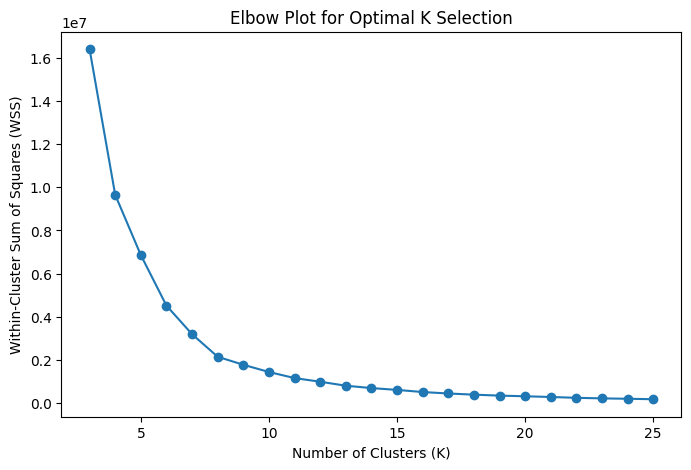

In [70]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [71]:
# Setting a K of 20 and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [72]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'relative_value', 'overall_ranking', 'position_rank', 'player_value_tier']]

In [73]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)